[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.

This tutorial demonstrates:

1. How to use TensorFlow Hub with `tf.keras`.
1. How to do image classification using TensorFlow Hub.
1. How to do simple transfer learning.

Compared to the original tutorial, the changes are:
1. Use of our own dataset (butterfly dataset)

## Setup

### Imports

In [1]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [2]:
!pip install -U tensorflow_hub
!pip install --user tf-nightly-gpu

     |████████████████████████████████| 468.5 MB 513 bytes/s 
     |████████████████████████████████| 463 kB 70.7 MB/s 
     |████████████████████████████████| 12.8 MB 137 kB/s 
     |████████████████████████████████| 2.3 MB 26.2 MB/s 
     |████████████████████████████████| 5.7 MB 23.0 MB/s 
     |████████████████████████████████| 1.3 MB 54.4 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf


## An ImageNet classifier

### Download the classifier

Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

Any [tf2 compatible image classifier url from tfhub.dev](https://tfhub.dev/s?q=tf2&module-type=image-classification) will work here.

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### Run it on a single image

Download a single image to try the model on.

671744/657369 [==============================] - 0s 0us/step


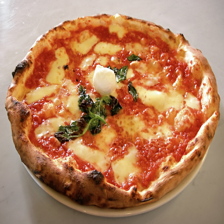

In [7]:
import numpy as np
import PIL.Image as Image

pizza = tf.keras.utils.get_file(fname = 'pizza.jpeg', origin = 'https://upload.wikimedia.org/wikipedia/commons/a/a3/Eq_it-na_pizza-margherita_sep2005_sml.jpg')
pizza = Image.open(pizza).resize(IMAGE_SHAPE)
pizza

In [8]:
pizza = np.array(pizza)/255
pizza.shape


(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [9]:
result = classifier.predict(pizza[np.newaxis, ...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

964

### Decode the predictions

We have the predicted class ID,
Fetch the `ImageNet` labels, and decode the predictions

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

24576/10484 [======================================================================] - 0s 0us/step


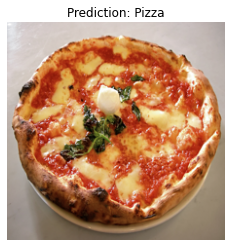

In [12]:
plt.imshow(pizza)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Simple transfer learning

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

# ALTERNATIVE DATASET

Here we import the butterfly dataset, containing 10 classes of 10 different species of butterfly

In [41]:
data_root = "/content/data"
get_ipython().system_raw(data_root)


The simplest way to load this data into our model is using tf.keras.preprocessing.image.ImageDataGenerator,

All of TensorFlow Hub's image modules expect float inputs in the [0, 1] range. Use the ImageDataGenerator's rescale parameter to achieve this.

The image size will be handled later.

In [42]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 72 images belonging to 3 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [23]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)


### Run the classifier on a batch of images

Now run the classifier on the image batch.

In [24]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [25]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['spotlight', 'spotlight', 'spotlight', 'spotlight', 'spotlight',
       'theater curtain', 'theater curtain', 'theater curtain',
       'matchstick', 'spotlight', 'nematode', 'spotlight', 'switch',
       'matchstick', 'matchstick', 'candle', 'spotlight', 'spotlight',
       'matchstick', 'spotlight', 'matchstick', 'matchstick',
       'theater curtain', 'matchstick', 'switch', 'spotlight',
       'spotlight', 'spotlight', 'candle', 'matchstick', 'spotlight',
       'matchstick'], dtype='<U30')

Now check how these predictions line up with the images:

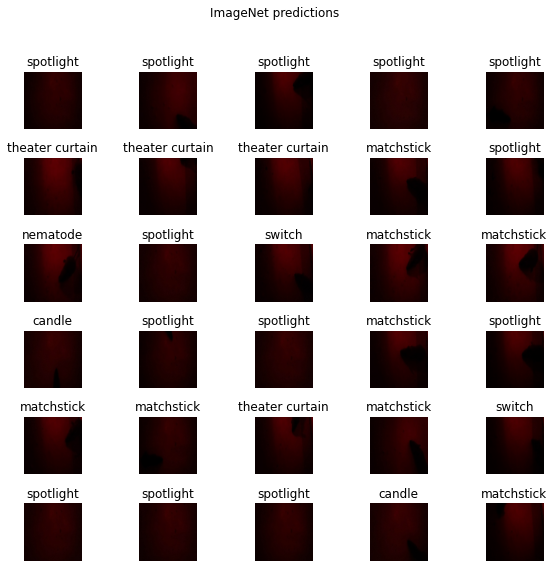

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The results are far from perfect, but reasonable considering that these are not the classes the model was trained for.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) will work here.

In [27]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3" #@param {type:"string"}

Create the module, and check the expected image size:

In [28]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

The feature extractor returns a 1280-element vector for each image.

In [29]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1536)


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [30]:
feature_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [31]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1536)              54336736  
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 4,611
Non-trainable params: 54,336,736
_________________________________________________________________


In [32]:
predictions = model(image_batch)

In [33]:
predictions.shape

TensorShape([32, 3])

### Train the model

Use compile to configure the training process:

In [34]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

Now use the `.fit` method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [35]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [36]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [38]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=3,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/3
3/3 [==============================] - 20s 6s/step - loss: 0.2831 - acc: 0.9375
Epoch 2/3
3/3 [==============================] - 13s 4s/step - loss: 0.0430 - acc: 1.0000
Epoch 3/3
3/3 [==============================] - 13s 6s/step - loss: 0.2383 - acc: 0.9062


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

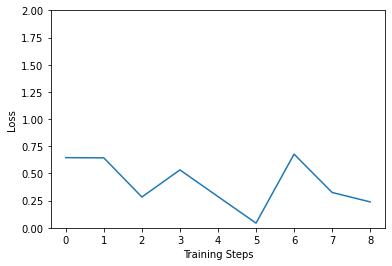

In [43]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

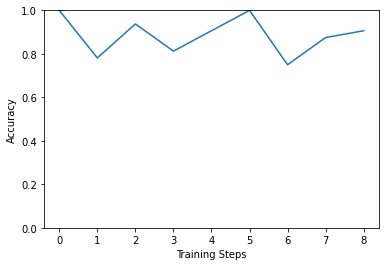

In [44]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [45]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['.Ipynb_Checkpoints', 'M', 'Nm'], dtype='<U18')

Run the image batch through the model and convert the indices to class names.

In [46]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

Plot the result

In [47]:
label_id = np.argmax(label_batch, axis=-1)

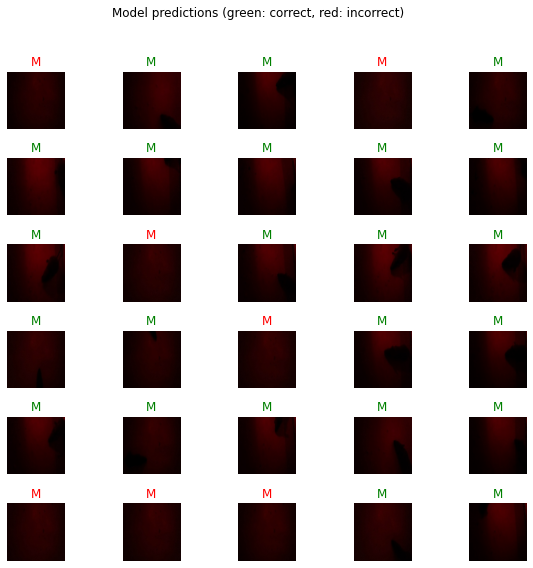

In [48]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Export your model

Now that you've trained the model, export it as a saved model:

In [49]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

AttributeError: ignored

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

